In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee
from qiskit_metal.analyses.quantization import EPRanalysis

from collections import OrderedDict
import numpy as np
from pyaedt import Hfss
import json
import pickle
from utils import *

In [3]:
from qiskit_metal import draw, Dict
from qiskit_metal.qlibrary.core import QComponent
import numpy as np


class CoupledLineTee(QComponent):
    """Generates a three pin (+) structure comprised of a primary two pin CPW
    transmission line, and a secondary one pin neighboring CPW transmission
    line that is capacitively/inductively coupled to the primary. Such a
    structure can be used, as an example, for generating CPW resonator hangars
    off of a transmission line.

    Inherits QComponent class.

    ::

        +----------------------------+
        ------------------------------
        |
        |
        |
        |
        +

    .. image::
        CoupledLineTee.png

    .. meta::
        Coupled Line Tee

    Default Options:
        * prime_width: '10um' -- The width of the trace of the two pin CPW transmission line
        * prime_gap: '6um' -- The dielectric gap of the two pin CPW transmission line
        * second_width: '10um' -- The width of the trace of the one pin CPW transmission line
        * second_gap: '6um' -- The dielectric gap of the one pin CPW transmission line
        * coupling_space: '3um' -- The amount of ground plane between the two transmission lines
        * coupling_length: '100um' -- The length of parallel between the two transmission lines
          note: this includes the distance of the curved second of the second line
        * down_length: '100um' -- The length of the hanging part of the resonator, including the curved region
        * fillet: '25um'
        * mirror: False -- Flips the hanger around the y-axis
        * open_termination: True -- sets if the termination of the second line at the coupling side
          is an open to ground or short to ground
    """
    component_metadata = Dict(short_name='cpw', _qgeometry_table_path='True')
    """Component metadata"""

    #Currently setting the primary CPW length based on the coupling_length
    #May want it to be it's own value that the user can control?
    default_options = Dict(prime_width='10um',
                           prime_gap='6um',
                           second_width='10um',
                           second_gap='6um',
                           coupling_space='3um',
                           coupling_length='100um',
                           down_length='100um',
                           fillet='25um',
                           mirror=False,
                           open_termination=True)
    """Default connector options"""

    TOOLTIP = """Generates a three pin (+) 
    structure comprised of a primary two 
    pin CPW transmission line, and a 
    secondary one pin neighboring CPW 
    transmission line that is 
    capacitively/inductively coupled 
    to the primary."""

    def make(self):
        """Build the component."""
        p = self.p

        prime_cpw_length = p.coupling_length * 2 * 1.5
        second_flip = 1
        if p.mirror:
            second_flip = -1

        #Primary CPW
        prime_cpw = draw.LineString([[-prime_cpw_length / 2, 0],
                                     [prime_cpw_length / 2, 0]])

        #Secondary CPW
        second_down_length = p.down_length
        second_y = -p.prime_width / 2 - p.prime_gap - p.coupling_space - p.second_gap - p.second_width / 2
        second_cpw = draw.LineString(
            [[second_flip * (-p.coupling_length / 2), second_y],
             [second_flip * (p.coupling_length / 2), second_y],
             [
                 second_flip * (p.coupling_length / 2),
                 second_y - second_down_length
             ]])

        second_termination = 0
        if p.open_termination:
            second_termination = p.second_gap

        second_cpw_etch = draw.LineString(
            [[
                second_flip * (-p.coupling_length / 2 - second_termination),
                second_y
            ], [second_flip * (p.coupling_length / 2), second_y],
             [
                 second_flip * (p.coupling_length / 2),
                 second_y - second_down_length
             ]])

        #Rotate and Translate
        c_items = [prime_cpw, second_cpw, second_cpw_etch]
        c_items = draw.rotate(c_items, p.orientation, origin=(0, 0))
        c_items = draw.translate(c_items, p.pos_x, p.pos_y)
        [prime_cpw, second_cpw, second_cpw_etch] = c_items

        #Add to qgeometry tables
        self.add_qgeometry('path', {'prime_cpw': prime_cpw},
                           width=p.prime_width)
        self.add_qgeometry('path', {'prime_cpw_sub': prime_cpw},
                           width=p.prime_width + 2 * p.prime_gap,
                           subtract=True)
        self.add_qgeometry('path', {'second_cpw': second_cpw},
                           width=p.second_width,
                           fillet=p.fillet)
        self.add_qgeometry('path', {'second_cpw_sub': second_cpw_etch},
                           width=p.second_width + 2 * p.second_gap,
                           subtract=True,
                           fillet=p.fillet)

        #Add pins
        prime_pin_list = prime_cpw.coords
        second_pin_list = second_cpw.coords

        self.add_pin('prime_start',
                     points=np.array(prime_pin_list[::-1]),
                     width=p.prime_width,
                     input_as_norm=True)
        self.add_pin('prime_end',
                     points=np.array(prime_pin_list),
                     width=p.prime_width,
                     input_as_norm=True)
        self.add_pin('second_end',
                     points=np.array(second_pin_list[1:]),
                     width=p.second_width,
                     input_as_norm=True)


In [4]:
def setup_metal_design():
    design = designs.design_planar.DesignPlanar()
    gui = MetalGUI(design)
    design.overwrite_enabled = True
    return design, gui

def set_chip_size(design, size_x='5mm', size_y='5mm'):
    design._chips.main.size.size_x = size_x
    design._chips.main.size.size_y = size_y

def create_qubit(design, qubit_name, claw_length, cross_length, inductance):
    xmon1_options = dict(
        connection_pads={
            connection_pad_name: dict(
                connector_location='90',
                connector_type='0',
                claw_length=claw_length,
                ground_spacing='4.1um',
                claw_gap='5.1um',
                claw_width='15um',
                claw_cpw_length=0
            ),
        },
        cross_width='30um',
        cross_length=cross_length,
        cross_gap='30um',
        orientation='-90',
        pos_x='-1500um',
        pos_y='1200um',
        aedt_hfss_inductance=inductance,
        hfss_inductance=inductance, 
        q3d_inductance=inductance,
        aedt_q3d_inductance=inductance
    )
    q1 = TransmonCross(design, qubit_name, options=xmon1_options)
    design.components[qubit_name].options['hfss_inductance'] = "9.686nH"

def create_feedline(design, feedline_name):
    clt1_opts = Dict(prime_width=cpw_width,
                     prime_gap='5.1um',
                     second_width=cpw_width,
                     second_gap='5.1um',
                     coupling_space='7.9um',
                     coupling_length='225um',
                     open_termination=False,
                     orientation='-90',
                     pos_y='1200um',
                     down_length='50um')
    clt1 = CoupledLineTee(design, feedline_name, clt1_opts)
    return clt1

def create_cavity(design, cavity_name, feedline_name, qubit_name):
    cpw1_opts = Dict(
        pin_inputs=Dict(
            start_pin=Dict(component=feedline_name,
                           pin='second_end'),
            end_pin=Dict(component=qubit_name,
                         pin=connection_pad_name)
        ),
        lead=Dict(end_straight='70um'),
        fillet='49.9um',
        total_length='3900um',
        trace_width=cpw_width,
        meander=Dict(spacing='100um', asymmetry='-150um'),
        trace_gap='5.1um'
    )
    cpw1 = RouteMeander(design, cavity_name, options = cpw1_opts)


In [5]:
def run_custom_eigenmodal_simulation(design, qubit_name, feedline_name, coupler, cavity_name, setup_name='Setup', index=0):
    eig_qres = EPRanalysis(design, "hfss")
    hfss = eig_qres.sim.renderer
    hfss.start()

    # Activate Ansys design
    hfss.new_ansys_design(f"TransmonCavity_{index}", 'eigenmode')
    hfss.render_design([qubit_name, feedline_name, cavity_name])  # List of components to include in the simulation
    # Customize simulation settings
    setup = hfss.pinfo.setup
    setup.n_modes = 2
    #setup.reuse_selected_design = True,
    #setup.reuse_setup =True,
    setup.passes = 15 #15
    setup.max_delta_f = 0.05 #0.02
    setup.min_freq = '2GHz'
    setup.max_passes = 50
    setup.min_coverged = 1
    #setup.basis_order = "Mixed Order"

    # Custom functionality to change material properties
    aedt = Hfss(projectname=hfss.pinfo.project_name, 
                designname=hfss.pinfo.design.name, 
                solution_type='eigenmode',
                new_desktop_session=False, 
                close_on_exit=False)
                
    materials = aedt.materials
    silicon = materials.checkifmaterialexists('silicon')
    silicon.permittivity = 11.45
    silicon.dielectric_loss_tangent = 1E-7

    Lj = design.components[qubit_name].options.aedt_hfss_inductance
    
    pinfo = hfss.pinfo
    pinfo.design.set_variable('Lj', f'{Lj} nH')
    pinfo.design.set_variable('Cj', '0 fF')

    pinfo = hfss.pinfo
    pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': f'JJ_rect_Lj_{qubit_name}_rect_jj',
                                 'line': f'JJ_Lj_{qubit_name}_rect_jj_',  'Cj_variable': 'Cj'}
    pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
    pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify

    modeler = hfss.pinfo.design.modeler

    mesh_lengths = {'mesh1': {"objects": [f"cross_{qubit_name}",f"readout_connector_arm_{qubit_name}",f"prime_cpw_{feedline_name}", f"second_cpw_{feedline_name}", f"trace_{cavity_name}", f"readout_connector_arm_{feedline_name}"], "MaxLength": '4um'},
                    'mesh2': {'objects': [f"JJ_rect_Lj_{qubit_name}_rect_jj"], "MaxLength": '2um'}
                    }
    
    # for mesh_name, mesh_info in mesh_lengths.items():
    #     modeler.mesh_length(mesh_name, mesh_info['objects'], MaxLength=mesh_info['MaxLength'])      

    add_ground_strip_and_mesh(modeler, coupler, mesh_lengths)
    
    setup.analyze()

    # Store printouts or any other information
    output_data = {
        'n_modes': setup.n_modes,
        'passes': setup.passes,
        'ansys_file_path': hfss.pinfo.project_path
    }

    return hfss, setup, output_data


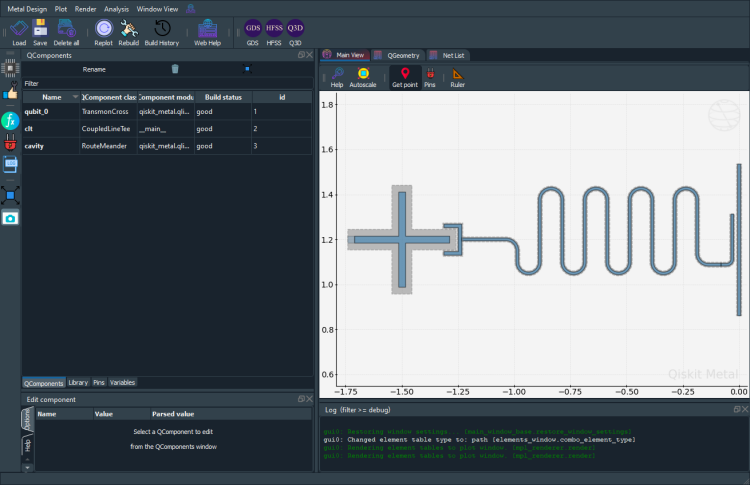

INFO 10:07PM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:07PM [load_ansys_project]: 	Opened Ansys App
INFO 10:07PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 10:07PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project38
INFO 10:07PM [connect_design]: 	Opened active design
	Design:    TransmonCavity_31 [Solution type: Eigenmode]
INFO 10:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:07PM [connect]: 	Connected to project "Project38" and design "TransmonCavity_31" 😀 

INFO 10:07PM [connect_design]: 	Opened active design
	Design:    TransmonCavity_0 [Solution type: Eigenmode]
WARNING 10:07PM [connect_setup]: 	No design setup detected.
WARNING 10:07PM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project Project38 set to active.


INFO:Global:Project Project38 set to active.


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\application\design_solutions.py", line 634, in solution_type


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\application\design_solutions.py", line 634, in solution_type


pyaedt ERROR: 'eigenmode' - solution_type -  KEY ERROR.


ERROR:Global:'eigenmode' - solution_type -  KEY ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     value = eigenmode 


ERROR:Global:    value = eigenmode 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=solution_type


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=solution_type


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: aedt file load time 0.14499545097351074


INFO:Global:aedt file load time 0.14499545097351074


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = main 


ERROR:Global:    name = main 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = sample_holder 


ERROR:Global:    name = sample_holder 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = prime_cpw_clt 


ERROR:Global:    name = prime_cpw_clt 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = second_cpw_clt 


ERROR:Global:    name = second_cpw_clt 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = trace_cavity 


ERROR:Global:    name = trace_cavity 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = cross_qubit_0 


ERROR:Global:    name = cross_qubit_0 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = readout_connector_arm_qubit_0 


ERROR:Global:    name = readout_connector_arm_qubit_0 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = JJ_rect_Lj_qubit_0_rect_jj 


ERROR:Global:    name = JJ_rect_Lj_qubit_0_rect_jj 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = ground_main_plane 


ERROR:Global:    name = ground_main_plane 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = JJ_Lj_qubit_0_rect_jj_ 


ERROR:Global:    name = JJ_Lj_qubit_0_rect_jj_ 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


ERROR:Global:Error in :   File "c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



ERROR:Global:Project: Project38, Design: TransmonCavity_31 (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (6:20:22 PM  Nov 02, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes
INFO 10:07PM [analyze]: Analyzing setup Setup


In [6]:
cpw_width = '11.7um'
connection_pad_name = 'readout'
cavity_name = 'cavity'
feedline_name = 'clt'

# Replace these lists with your ML-predicted values
# predicted_cross_length =[ 97.2,  95.6, 150. , 127.6, 210 ]
# predicted_claw_length = [ 70 ,  83.5, 126.2, 100.7,  70.6]
predicted_cross_length = [211.36686180080213, 239.67001841727927, 199.29546197022296, 272.80405439803087, 166.21118594572997]
predicted_claw_length = [62.74561331858793, 238.54614619784087, 166.65135380618355, 49.04728878924247, 122.98283288276569]
Lj_vals = [10.130278903289723, 8.837126261668763, 10.545628251119771, 7.934490145874526, 12.130125654474945]
setups, hfsss = [], []

for i, (cross_length, claw_length, Lj) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals)):
    # i+=3
    design, gui = setup_metal_design()
    set_chip_size(design)
    
    qubit_name = f'qubit_{i}'
    xmon = create_qubit(design, qubit_name, f'{claw_length}um', f'{cross_length}um', Lj)
    clt = create_feedline(design, feedline_name)
    cavity = create_cavity(design, cavity_name, feedline_name, qubit_name)

    gui.rebuild()
    gui.zoom_on_components([qubit_name, cavity_name, feedline_name])

    # Save screenshot
    screenshot_path = f"screenshot_{i}.png"  # Change the file path and format as needed
    gui.screenshot(screenshot_path)
    #gui.main_window.close()
    
    ansys_data = {}

    # Run custom Eigenmodal Simulation
    hfss, setup, output_data = run_custom_eigenmodal_simulation(design, qubit_name, feedline_name, clt, cavity_name, index=i)
    ansys_data[qubit_name] = output_data
    hfsss.append(hfss)
    setups.append(setup)
    setup.vars.Lj = Lj

    # Update JSON file after each loop
    with open('ansys_data.json', 'w') as f:
        json.dump(ansys_data, f)

    # Clear design for the next iteration
    design.delete_all_components()


# EPR Analysis

In [ ]:
import pyEPR as epr
path = r"D:\lfl\Documents\Ansoft"

# 1. Connect to your Ansys, and load your design
pinfo = epr.ProjectInfo(project_path = path, #path to the project file
                        project_name = r'Project38',
                        design_name  = r'TransmonCavity_4')

# check to see if file is okay
print(pinfo.design.solution_type)

print(pinfo.setup.get_mesh_stats())

INFO 12:29PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:29PM [load_ansys_project]: 	File path to HFSS project found.
INFO 12:29PM [load_ansys_project]: 	Opened Ansys App
INFO 12:29PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 12:29PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project38
INFO 12:29PM [connect_design]: 	Opened active design
	Design:    TransmonCavity_4 [Solution type: Eigenmode]
INFO 12:29PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:29PM [connect]: 	Connected to project "Project38" and design "TransmonCavity_4" 😀 



Eigenmode
       Unnamed: 0  Num Tets    Min edge length    Max edge length    \
0           main      2763303           0.000097           0.462885   
1  sample_holder      1685303           0.000158           0.498515   

   RMS edge length    Min tet vol    Max tet vol    Mean tet vol    \
0           0.011516   6.597590e-14       0.003164    6.243890e-07   
1           0.017067   1.298770e-13       0.004961    2.443420e-06   

   Std Devn (vol)    
0          0.000022  
1          0.000068  


In [ ]:
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify

In [ ]:
qubit_name = "qubit_4"

In [ ]:
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': f'JJ_rect_Lj_{qubit_name}_rect_jj',
                            'line': f'JJ_Lj_{qubit_name}_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied

In [ ]:
pinfo.junctions

{'jj': {'Lj_variable': 'Lj',
  'rect': 'JJ_rect_Lj_qubit_4_rect_jj',
  'line': 'JJ_Lj_qubit_4_rect_jj_',
  'Cj_variable': 'Cj'}}

In [ ]:
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 
eprh.get_ansys_frequencies_all()

Design "TransmonCavity_4" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        4.808487    1.088517e+07
          1        6.825551    1.089208e+07

In [ ]:
eprh.do_EPR_analysis()

c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),



Variation 0  [1/1]


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:1101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Ljs = pd.Series({})
c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:1102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Cjs = pd.Series({})
c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 0 at 4.81 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.8%  7.556e-27 9.231e-29

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 98.26%
	jj              0.987253  (+)        0.0174574
		(U_tot_cap-U_tot_ind)/mean=0.89%
Calculating Qdielectric_main for mode 0 (0/1)


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_main_0 = 0.9186812882025621


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(
c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:1245: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _Om = pd.Series({})



  Mode 1 at 6.83 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  6.359e-27 6.357e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:981: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Sj = pd.Series({})


		Energy fraction (Lj over Lj&Cj)= 96.56%
	jj              0.000263733  (+)        9.39667e-06
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 1 (1/1)


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:933: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Qp = pd.Series({})


p_dielectric_main_1 = 0.9180983031475287


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_distributed_analysis.py:1307: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol = sol.append(self.get_Qdielectric(



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project38\TransmonCavity_4\2023-11-02 12-39-23.npz




c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\project_info.py:239: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  options=pd.Series(get_instance_vars(self.options)),


(WindowsPath('C:/data-pyEPR/Project38/TransmonCavity_4/2023-11-02 12-39-23.npz'),
 ['0'])

In [ ]:
eprh.data_filename

WindowsPath('C:/data-pyEPR/Project38/TransmonCavity_4/2023-11-02 12-39-23.npz')

In [ ]:
epra = epr.QuantumAnalysis(eprh.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15)

WARNING 12:44PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018110
1    1.015255
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.970314
1  0.000264

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
   0.00026

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       167    0.127
     0.127  2.4e-05

*** Chi matrix ND (MHz) 
       183    0.108
     0.108 1.79e-05

*** Frequencies O1 PT (MHz)
0    4641.287629
1    6825.487572
dtype: float64

*** Frequencies ND (MHz)
0    4634.941824
1    6825.490368
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_quantum_analysis.py:712: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions
c:\Users\lfl\.conda\envs\qiskit_metal\Lib\site-packages\pyEPR\core_quantum_analysis.py:717: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions


OrderedDict([('0',
              OrderedDict([('f_0', 0    4808.486886
                            1    6825.550932
                            Name: 0, dtype: float64),
                           ('f_1',
                            0    4641.287629
                            1    6825.487572
                            dtype: float64),
                           ('f_ND',
                            0    4634.941824
                            1    6825.490368
                            dtype: float64),
                           ('chi_O1',
                                        0         1
                            0  167.135921  0.126673
                            1    0.126673  0.000024),
                           ('chi_ND',
                                        0         1
                            0  182.615698  0.107875
                            1    0.107875  0.000018),
                           ('ZPF',
                            array([[0.37515193],
             

In [ ]:
import cmath

def compute_g_from_EPR(chi, alpha, Delta, Sigma):
    """
    Compute the value of g based on the provided formula.

    Parameters:
    - chi (float): Full Dispersive Shift (MHz)
    - alpha (float): Anharmonicity (MHz)
    - Delta (float): w_res - w_q(MHz)
    - Sigma (float): w_q + w_res(MHz)

    Returns:
    - float: The computed value of g (MHz).
    """
    
    # Validate the inputs to ensure no mathematical errors during computation
    if Delta == alpha:
        raise ValueError("Denominator will be zero due to Δ - α being zero.")
    if Sigma == -alpha:
        raise ValueError("Denominator will be zero due to Σ + α being zero.")

    # Compute the individual components of the formula
    term1 = alpha / (Delta * (Delta - alpha))
    term2 = alpha / (Sigma * (Sigma + alpha))

    # Combine the terms to compute g
    g = cmath.sqrt(chi) / (cmath.sqrt(2) * cmath.sqrt(term1 + term2))

    return g

In [ ]:
epra.get_frequencies()["0"][0]

4634.9418241265175

In [ ]:
epra

NameError: name 'epra' is not defined

In [ ]:
# get from epra
chi =  -abs(epra.get_chis()[0][1]) # - abs(kerr_matrix[0][1])
alpha = -abs(epra.get_chis()[0][0]) # - abs(kerr_matrix[0][0])
w_res= epra.get_frequencies()["0"][1] # MHz
w_q= epra.get_frequencies()["0"][0] # MHz
Delta = w_res - w_q
Sigma = w_res + w_q

result = compute_g_from_EPR(chi, alpha, Delta, Sigma)
print(f"g = {result.real} MHz; alpha = {alpha} MHz")

NameError: name 'epra' is not defined

1. change code to update cpw_len and coupling_len also
2. Do EPR analysis on site, save to disk